In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import warnings

# Suppress font warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# Configure matplotlib for Korean font support
def setup_korean_font():
    """Setup matplotlib to display Korean characters properly"""
    # Cross-platform Korean fonts (macOS, Windows, Linux)
    korean_fonts = [
        'AppleGothic',       # macOS
        'Malgun Gothic',     # Windows
        'NanumGothic',       # Cross-platform
        'Nanum Gothic',      # Alternative name
        'NanumBarunGothic',  # Alternative
        'UnDotum',           # Linux
    ]
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in korean_fonts:
        if font in available_fonts:
            plt.rc('font', family=font)
            plt.rc('axes', unicode_minus=False)
            print(f"✓ Korean font set to: {font}")
            return True
    
    # Fallback: use sans-serif and disable font warnings
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    print("⚠ No Korean font found, using fallback. Korean text may not display correctly.")
    return False

def get_korean_font():
    """Get Korean font properties for explicit text rendering"""
    korean_fonts = [
        'AppleGothic',       # macOS
        'Malgun Gothic',     # Windows
        'NanumGothic',       # Cross-platform
        'Nanum Gothic',      # Alternative name
        'NanumBarunGothic',  # Alternative
        'UnDotum',           # Linux
    ]
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in korean_fonts:
        if font in available_fonts:
            return FontProperties(family=font)
    
    # Fallback
    return FontProperties(family='sans-serif')

setup_korean_font()

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully")

✓ Korean font set to: AppleGothic
Libraries imported successfully


In [2]:
# Connect to DuckDB
db_path = Path.cwd() / "../data/data.duckdb"
conn = duckdb.connect(str(db_path), read_only=True)

print(f"Connected to DuckDB at: {db_path}")
print(f"Database exists: {db_path.exists()}")

Connected to DuckDB at: /Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/notebooks/../data/data.duckdb
Database exists: True


In [3]:
# Load industry codes and names
industry_codes_df = conn.execute("""
    SELECT code, name, market 
    FROM industry_codes 
    ORDER BY code
""").df()

print(f"Total industries: {len(industry_codes_df)}")
print("\nSample industry codes:")
display(industry_codes_df.head(10))

Total industries: 65

Sample industry codes:


,code,name,market
0,001,종합(KOSPI),KOSPI
1,002,대형주,KOSPI
2,003,중형주,KOSPI
3,004,소형주,KOSPI
4,005,음식료/담배,KOSPI
5,006,섬유/의류,KOSPI
6,007,종이/목재,KOSPI
7,008,화학,KOSPI
8,009,제약,KOSPI
9,010,비금속,KOSPI


In [4]:
# Load industry daily chart data
daily_charts_df = conn.execute("""
    SELECT 
        industry_code,
        date,
        close,
        volume,
        trading_amount
    FROM industry_daily_charts
    ORDER BY industry_code, date
""").df()

# Convert date to datetime
daily_charts_df['date'] = pd.to_datetime(daily_charts_df['date'])

print(f"Total daily records: {len(daily_charts_df):,}")
print(f"Date range: {daily_charts_df['date'].min()} to {daily_charts_df['date'].max()}")
print(f"Industries with data: {daily_charts_df['industry_code'].nunique()}")
print("\nSample data:")
display(daily_charts_df.head(10))

Total daily records: 44,912
Date range: 2022-11-02 00:00:00 to 2025-10-31 00:00:00
Industries with data: 65

Sample data:


,industry_code,date,close,volume,trading_amount
0,001,2022-11-02,233687,450634,9568100
1,001,2022-11-03,232917,550428,9273251
2,001,2022-11-04,234843,436430,7927339
3,001,2022-11-07,237179,392508,8059881
4,001,2022-11-08,239904,500087,8601453
5,001,2022-11-09,242441,680722,9342671
6,001,2022-11-10,240223,899127,9344425
7,001,2022-11-11,248316,758247,13917647
8,001,2022-11-14,247465,731166,11216385
9,001,2022-11-15,248033,617401,9308852


In [5]:
# Pivot data for easier RS calculations
price_pivot = daily_charts_df.pivot(index='date', columns='industry_code', values='close')

# Sort by date
price_pivot = price_pivot.sort_index()

print(f"Price matrix shape: {price_pivot.shape}")
print(f"Date range: {price_pivot.index.min()} to {price_pivot.index.max()}")
print(f"Industries: {len(price_pivot.columns)}")
print("\nSample price data:")
display(price_pivot.tail())

Price matrix shape: (732, 65)
Date range: 2022-11-02 00:00:00 to 2025-10-31 00:00:00
Industries: 65

Sample price data:


industry_code,001,002,003,004,005,006,007,008,009,010,011,012,013,014,015,016,017,018,019,020,021,024,025,026,027,028,029,030,101,103,106,107,108,110,111,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,138,139,140,141,142,143,144,145,150,151,160,165,603,604,605
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-10-27,404283.0,417402.0,379092.0,250724.0,448351.0,23090.0,27246.0,447852.0,1750984.0,415634.0,655356.0,300728.0,4454200.0,152699.0,495767.0,45093.0,130649.0,10136.0,184933.0,48247.0,75810.0,441781.0,2998415.0,141936.0,1087095.0,97297.0,127918.0,135596.0,90270.0,551076.0,283980.0,7620.0,46490.0,271949.0,149960.0,522610.0,4365.0,870699.0,218530.0,260191.0,1179695.0,5141134.0,205109.0,60355.0,151938.0,212896.0,484561.0,66895.0,115537.0,91186.0,222146.0,83658.0,261265.0,55610.0,192381.0,143911.0,153182.0,738004.0,155202.0,198581.0,179769.0,31092.0,3294.0,387111.0,523663.0
2025-10-28,401041.0,413337.0,380758.0,250874.0,448902.0,23024.0,27225.0,451109.0,1770363.0,415405.0,649901.0,305163.0,4398598.0,151383.0,484474.0,44345.0,133223.0,10055.0,184445.0,48232.0,75056.0,441068.0,2973073.0,141848.0,1076980.0,97457.0,129300.0,136516.0,90330.0,548000.0,283907.0,7914.0,46732.0,271825.0,153114.0,522166.0,4305.0,867825.0,220788.0,260301.0,1187731.0,5063393.0,203264.0,59753.0,152629.0,213300.0,477750.0,68272.0,115807.0,91303.0,222536.0,83639.0,261192.0,55747.0,191728.0,145393.0,154004.0,737291.0,155103.0,198420.0,179792.0,31090.0,3324.0,386546.0,523111.0
2025-10-29,408115.0,421814.0,381045.0,249398.0,444652.0,22564.0,27105.0,452020.0,1748667.0,410866.0,663593.0,324744.0,4527619.0,152772.0,486988.0,46585.0,136853.0,10334.0,182517.0,48334.0,75194.0,438836.0,2949860.0,140679.0,1099170.0,97505.0,134241.0,135027.0,90159.0,539111.0,285022.0,7877.0,46178.0,269953.0,149309.0,515750.0,4064.0,855317.0,218053.0,259362.0,1175793.0,5039527.0,202493.0,60822.0,154566.0,212383.0,481689.0,66777.0,115761.0,91083.0,221558.0,84030.0,260123.0,55066.0,191662.0,144849.0,153162.0,736870.0,154563.0,196736.0,178692.0,31282.0,3263.0,384588.0,527036.0
2025-10-30,408689.0,423604.0,374012.0,246096.0,449013.0,22265.0,26804.0,446066.0,1737470.0,402860.0,646288.0,310317.0,4603424.0,148577.0,493200.0,45848.0,130247.0,9903.0,183744.0,47430.0,74841.0,438134.0,2927690.0,138249.0,1107282.0,97520.0,128905.0,138742.0,89086.0,541463.0,280945.0,7858.0,45995.0,267447.0,144063.0,510136.0,3966.0,831583.0,217234.0,252692.0,1171581.0,4995773.0,198340.0,60161.0,151166.0,210295.0,473275.0,65451.0,114194.0,89351.0,219840.0,82741.0,255531.0,55318.0,189570.0,141440.0,150246.0,738126.0,153057.0,194920.0,176920.0,31594.0,3189.0,382006.0,525527.0
2025-10-31,410750.0,425975.0,375053.0,245449.0,450007.0,22216.0,26685.0,441414.0,1750113.0,398600.0,631785.0,308851.0,4642892.0,149249.0,500539.0,45549.0,129036.0,9920.0,187348.0,47491.0,74326.0,442144.0,2888231.0,136919.0,1114191.0,96839.0,134456.0,142812.0,90042.0,559838.0,283328.0,7895.0,45793.0,265706.0,142984.0,507540.0,3931.0,820225.0,216760.0,250050.0,1190642.0,4945095.0,197893.0,61893.0,150478.0,212461.0,476460.0,64867.0,114532.0,90175.0,223999.0,83093.0,255930.0,55335.0,189645.0,142877.0,150566.0,775598.0,154934.0,196107.0,178888.0,31244.0,3040.0,382618.0,528724.0


In [6]:
def calculate_rs(price_df, periods={'14d': 14, '1m': 21, '3m': 63, '6m': 126}):
    """
    Calculate Relative Strength (RS) for industries.
    
    RS = (Industry % change) / (Equal-weighted market average % change)
    RS > 1.0 means outperforming market
    RS < 1.0 means underperforming market
    
    Args:
        price_df: DataFrame with date index and industry_code columns
        periods: Dict of period names and their lookback days
        
    Returns:
        Dict of DataFrames containing RS values for each period
    """
    rs_results = {}
    
    for period_name, lookback_days in periods.items():
        # Calculate percent change for each industry (explicitly disable fill_method)
        pct_change = price_df.pct_change(periods=lookback_days, fill_method=None)
        
        # Calculate equal-weighted market average percent change
        market_avg_pct_change = pct_change.mean(axis=1)
        
        # Calculate RS as ratio: (Industry % change) / (Market avg % change)
        rs_df = pct_change.div(market_avg_pct_change, axis=0)
        
        # Replace inf/-inf with NaN
        rs_df = rs_df.replace([np.inf, -np.inf], np.nan)
        
        rs_results[period_name] = rs_df
        
        print(f"✓ Calculated RS for {period_name} (lookback: {lookback_days} days)")
        print(f"  Latest date: {rs_df.index[-1]}")
        print(f"  Valid RS values: {rs_df.iloc[-1].notna().sum()}/{len(rs_df.columns)}\n")
    
    return rs_results

# Calculate RS for all periods
rs_data = calculate_rs(price_pivot)

print("\nRS Calculation Complete!")

✓ Calculated RS for 14d (lookback: 14 days)
  Latest date: 2025-10-31 00:00:00
  Valid RS values: 65/65

✓ Calculated RS for 1m (lookback: 21 days)
  Latest date: 2025-10-31 00:00:00
  Valid RS values: 65/65

✓ Calculated RS for 3m (lookback: 63 days)
  Latest date: 2025-10-31 00:00:00
  Valid RS values: 65/65

✓ Calculated RS for 6m (lookback: 126 days)
  Latest date: 2025-10-31 00:00:00
  Valid RS values: 65/65


RS Calculation Complete!


In [7]:
# Get current RS rankings for each period
current_rs = {}
for period, rs_df in rs_data.items():
    latest_rs = rs_df.iloc[-1].dropna().sort_values(ascending=False)
    current_rs[period] = latest_rs

print("Current RS Rankings (Latest):\n")
for period in ['14d', '1m', '3m', '6m']:
    top5 = current_rs[period].head(5)
    bottom5 = current_rs[period].tail(5)
    
    print(f"\n{period.upper()} Period:")
    print("  Top 5 Strongest:")
    for code, rs_val in top5.items():
        name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0] if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
        print(f"    {code} ({name[:20]}): RS = {rs_val:.3f}")
    
    print("  Bottom 5 Weakest:")
    for code, rs_val in bottom5.items():
        name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0] if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
        print(f"    {code} ({name[:20]}): RS = {rs_val:.3f}")

Current RS Rankings (Latest):


14D Period:
  Top 5 Strongest:
    111 (금융): RS = 7.315
    013 (전기/전자): RS = 4.980
    027 (제조): RS = 3.880
    017 (전기/가스): RS = 3.440
    002 (대형주): RS = 3.382
  Bottom 5 Weakest:
    116 (섬유/의류): RS = -0.666
    115 (음식료/담배): RS = -1.173
    127 (기타제조): RS = -1.499
    121 (비금속): RS = -1.649
    165 (F-KOSDAQ150인버스): RS = -1.700

1M Period:
  Top 5 Strongest:
    603 (변동성지수): RS = 8.210
    013 (전기/전자): RS = 6.018
    111 (금융): RS = 5.480
    012 (기계/장비): RS = 4.747
    027 (제조): RS = 4.267
  Bottom 5 Weakest:
    127 (기타제조): RS = -1.109
    129 (IT 서비스): RS = -1.117
    128 (통신): RS = -1.240
    165 (F-KOSDAQ150인버스): RS = -1.437
    115 (음식료/담배): RS = -1.620

3M Period:
  Top 5 Strongest:
    013 (전기/전자): RS = 6.681
    027 (제조): RS = 4.090
    603 (변동성지수): RS = 3.899
    123 (기계/장비): RS = 3.870
    012 (기계/장비): RS = 3.710
  Bottom 5 Weakest:
    127 (기타제조): RS = -0.981
    110 (운송/창고): RS = -1.103
    128 (통신): RS = -1.116
    165 (F-KOSDAQ150인버스):

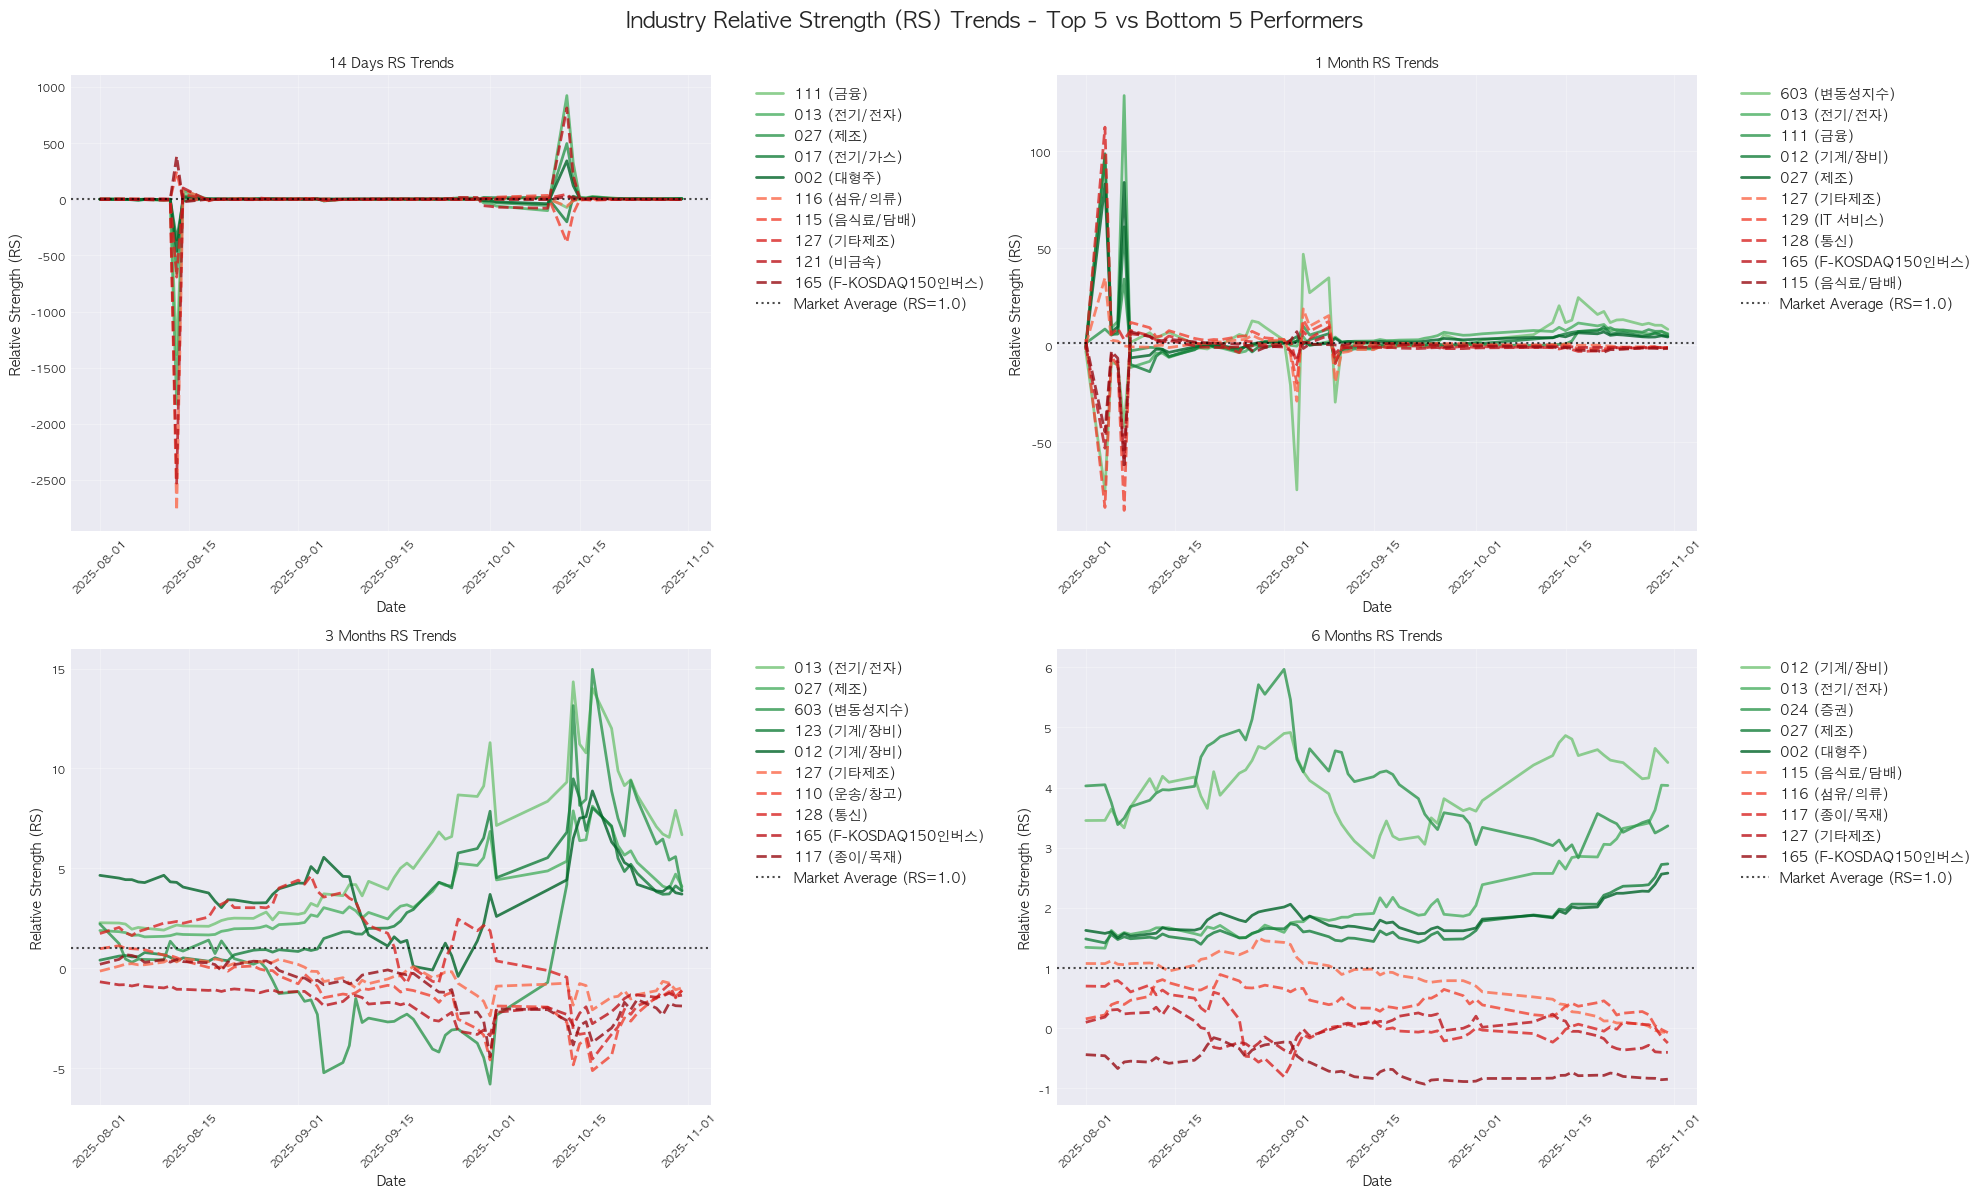

In [8]:
# RS Trend Line Charts - Show top 5 and bottom 5 performers
def plot_rs_trends(rs_data, current_rs, industry_codes_df, n_show=5):
    """Plot RS trend lines for top and bottom performers"""
    
    # Get Korean font for text rendering
    korean_font = get_korean_font()
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Industry Relative Strength (RS) Trends - Top 5 vs Bottom 5 Performers', 
                 fontsize=16, fontweight='bold', y=0.995, fontproperties=korean_font)
    
    axes = axes.flatten()
    periods = ['14d', '1m', '3m', '6m']
    period_labels = {'14d': '14 Days', '1m': '1 Month', '3m': '3 Months', '6m': '6 Months'}
    
    for idx, period in enumerate(periods):
        ax = axes[idx]
        
        # Get top and bottom performers
        top_codes = current_rs[period].head(n_show).index
        bottom_codes = current_rs[period].tail(n_show).index
        
        # Plot RS trends for last 60 days
        rs_df = rs_data[period].iloc[-60:]
        
        # Plot top performers (green shades)
        for i, code in enumerate(top_codes):
            if code in rs_df.columns:
                name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0] if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
                label = f"{code} ({name})"  # Don't truncate Korean text
                ax.plot(rs_df.index, rs_df[code], linewidth=2, alpha=0.8, 
                       color=plt.cm.Greens(0.5 + i*0.1), label=label)
        
        # Plot bottom performers (red shades)
        for i, code in enumerate(bottom_codes):
            if code in rs_df.columns:
                name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0] if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
                label = f"{code} ({name})"  # Don't truncate Korean text
                ax.plot(rs_df.index, rs_df[code], linewidth=2, alpha=0.8, 
                       color=plt.cm.Reds(0.5 + i*0.1), label=label, linestyle='--')
        
        # Add horizontal line at RS = 1.0 (market average)
        ax.axhline(y=1.0, color='black', linestyle=':', linewidth=1.5, alpha=0.7, label='Market Average (RS=1.0)')
        
        ax.set_title(f'{period_labels[period]} RS Trends', fontsize=12, fontweight='bold', fontproperties=korean_font)
        ax.set_xlabel('Date', fontsize=10, fontproperties=korean_font)
        ax.set_ylabel('Relative Strength (RS)', fontsize=10, fontproperties=korean_font)
        
        # Create legend with Korean font support
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, prop=korean_font)
        
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Apply Korean font to tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(korean_font)
        
        # Format x-axis
        ax.tick_params(labelsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot RS trends
plot_rs_trends(rs_data, current_rs, industry_codes_df)

In [9]:
# Create RS Ranking Table with all periods
def create_rs_ranking_table(current_rs, industry_codes_df):
    """Create a comprehensive ranking table showing RS across all periods"""
    
    # Create DataFrame with RS values for all periods
    ranking_data = []
    
    for code in industry_codes_df['code']:
        row = {'code': code}
        
        # Get industry name
        name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0]
        market = industry_codes_df[industry_codes_df['code'] == code]['market'].values[0] if 'market' in industry_codes_df.columns else ''
        row['name'] = name
        row['market'] = market if pd.notna(market) else ''
        
        # Get RS values for each period
        for period in ['14d', '1m', '3m', '6m']:
            if code in current_rs[period].index:
                row[f'rs_{period}'] = current_rs[period][code]
            else:
                row[f'rs_{period}'] = np.nan
        
        ranking_data.append(row)
    
    ranking_df = pd.DataFrame(ranking_data)
    
    # Calculate average RS across all periods
    ranking_df['rs_avg'] = ranking_df[['rs_14d', 'rs_1m', 'rs_3m', 'rs_6m']].mean(axis=1)
    
    # Sort by average RS (descending)
    ranking_df = ranking_df.sort_values('rs_avg', ascending=False)
    
    # Add rank column
    ranking_df['rank'] = range(1, len(ranking_df) + 1)
    
    # Reorder columns
    ranking_df = ranking_df[['rank', 'code', 'name', 'market', 'rs_14d', 'rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']]
    
    return ranking_df

# Create ranking table
rs_ranking = create_rs_ranking_table(current_rs, industry_codes_df)

print("Industry RS Rankings (Sorted by Average RS):\n")
print("=" * 120)
display(rs_ranking.head(20))
print("\n...")
display(rs_ranking.tail(20))

Industry RS Rankings (Sorted by Average RS):



,rank,code,name,market,rs_14d,rs_1m,rs_3m,rs_6m,rs_avg
12,1,013,전기/전자,KOSPI,4.980181,6.017904,6.681408,4.035269,5.428691
34,2,111,금융,KOSDAQ,7.314991,5.480228,3.280155,1.780313,4.463922
11,3,012,기계/장비,KOSPI,2.377068,4.746780,3.710110,4.417092,3.812763
62,4,603,변동성지수,KOSPI,1.771649,8.209919,3.898813,1.253020,3.783350
24,5,027,제조,KOSPI,3.879597,4.266581,4.089770,2.731844,3.741948
1,6,002,대형주,KOSPI,3.381674,3.634938,3.488594,2.578087,3.270823
0,7,001,종합(KOSPI),KOSPI,3.056876,3.173538,3.018382,2.329979,2.894694
21,8,024,증권,KOSPI,2.927896,2.365249,2.132992,3.363905,2.697510
14,9,015,운송장비/부품,KOSPI,3.339024,2.453164,2.236975,1.810639,2.459950
43,10,123,기계/장비,KOSDAQ,1.279138,2.254031,3.870070,1.745980,2.287305



...


,rank,code,name,market,rs_14d,rs_1m,rs_3m,rs_6m,rs_avg
25,46,028,부동산,KOSPI,0.120122,0.083518,0.480348,0.128846,0.203209
3,47,004,소형주,KOSPI,0.181252,-0.173630,-0.109291,0.432127,0.082615
42,48,122,금속,KOSDAQ,-0.538198,-0.124960,0.329207,0.356905,0.005738
52,49,140,KOSDAQ SMALL,KOSDAQ,-0.257555,-0.358911,0.144556,0.247728,-0.056045
45,50,125,의료/정밀기기,KOSDAQ,-0.353509,-0.688215,0.147100,0.351982,-0.135661
4,51,005,음식료/담배,KOSPI,-0.381666,-0.558548,-0.190126,0.388734,-0.185401
6,52,007,종이/목재,KOSPI,-0.036840,-0.337722,-0.309815,-0.059665,-0.186010
53,53,141,오락/문화,KOSDAQ,-0.628103,-0.609633,0.000585,0.312704,-0.231112
32,54,108,유통,KOSDAQ,-0.595274,-0.487120,-0.469374,0.375325,-0.294111
19,55,020,통신,KOSPI,-0.321911,-0.558365,-0.609345,0.023251,-0.366592


In [10]:
# Calculate RS Momentum (Rate of Change of RS)
def calculate_rs_momentum(rs_data, momentum_period=10):
    """
    Calculate RS momentum as rate of change of RS over specified period.
    Positive momentum = RS is improving
    Negative momentum = RS is deteriorating
    
    Args:
        rs_data: Dict of RS DataFrames
        momentum_period: Number of days to calculate momentum (default: 10 days)
        
    Returns:
        Dict of DataFrames containing RS momentum values
    """
    rs_momentum = {}
    
    for period_name, rs_df in rs_data.items():
        # Calculate percentage change in RS over momentum_period days (explicitly disable fill_method)
        momentum_df = rs_df.pct_change(periods=momentum_period, fill_method=None) * 100
        
        rs_momentum[period_name] = momentum_df
        
        print(f"✓ Calculated RS Momentum for {period_name} (lookback: {momentum_period} days)")
        print(f"  Latest date: {momentum_df.index[-1]}")
        print(f"  Valid momentum values: {momentum_df.iloc[-1].notna().sum()}/{len(momentum_df.columns)}\n")
    
    return rs_momentum

# Calculate RS momentum
rs_momentum = calculate_rs_momentum(rs_data, momentum_period=10)

# Get current momentum values
current_momentum = {}
for period, mom_df in rs_momentum.items():
    latest_mom = mom_df.iloc[-1].dropna().sort_values(ascending=False)
    current_momentum[period] = latest_mom

print("\nRS Momentum Analysis Complete!")

✓ Calculated RS Momentum for 14d (lookback: 10 days)
  Latest date: 2025-10-31 00:00:00
  Valid momentum values: 65/65

✓ Calculated RS Momentum for 1m (lookback: 10 days)
  Latest date: 2025-10-31 00:00:00
  Valid momentum values: 65/65

✓ Calculated RS Momentum for 3m (lookback: 10 days)
  Latest date: 2025-10-31 00:00:00
  Valid momentum values: 65/65

✓ Calculated RS Momentum for 6m (lookback: 10 days)
  Latest date: 2025-10-31 00:00:00
  Valid momentum values: 65/65


RS Momentum Analysis Complete!


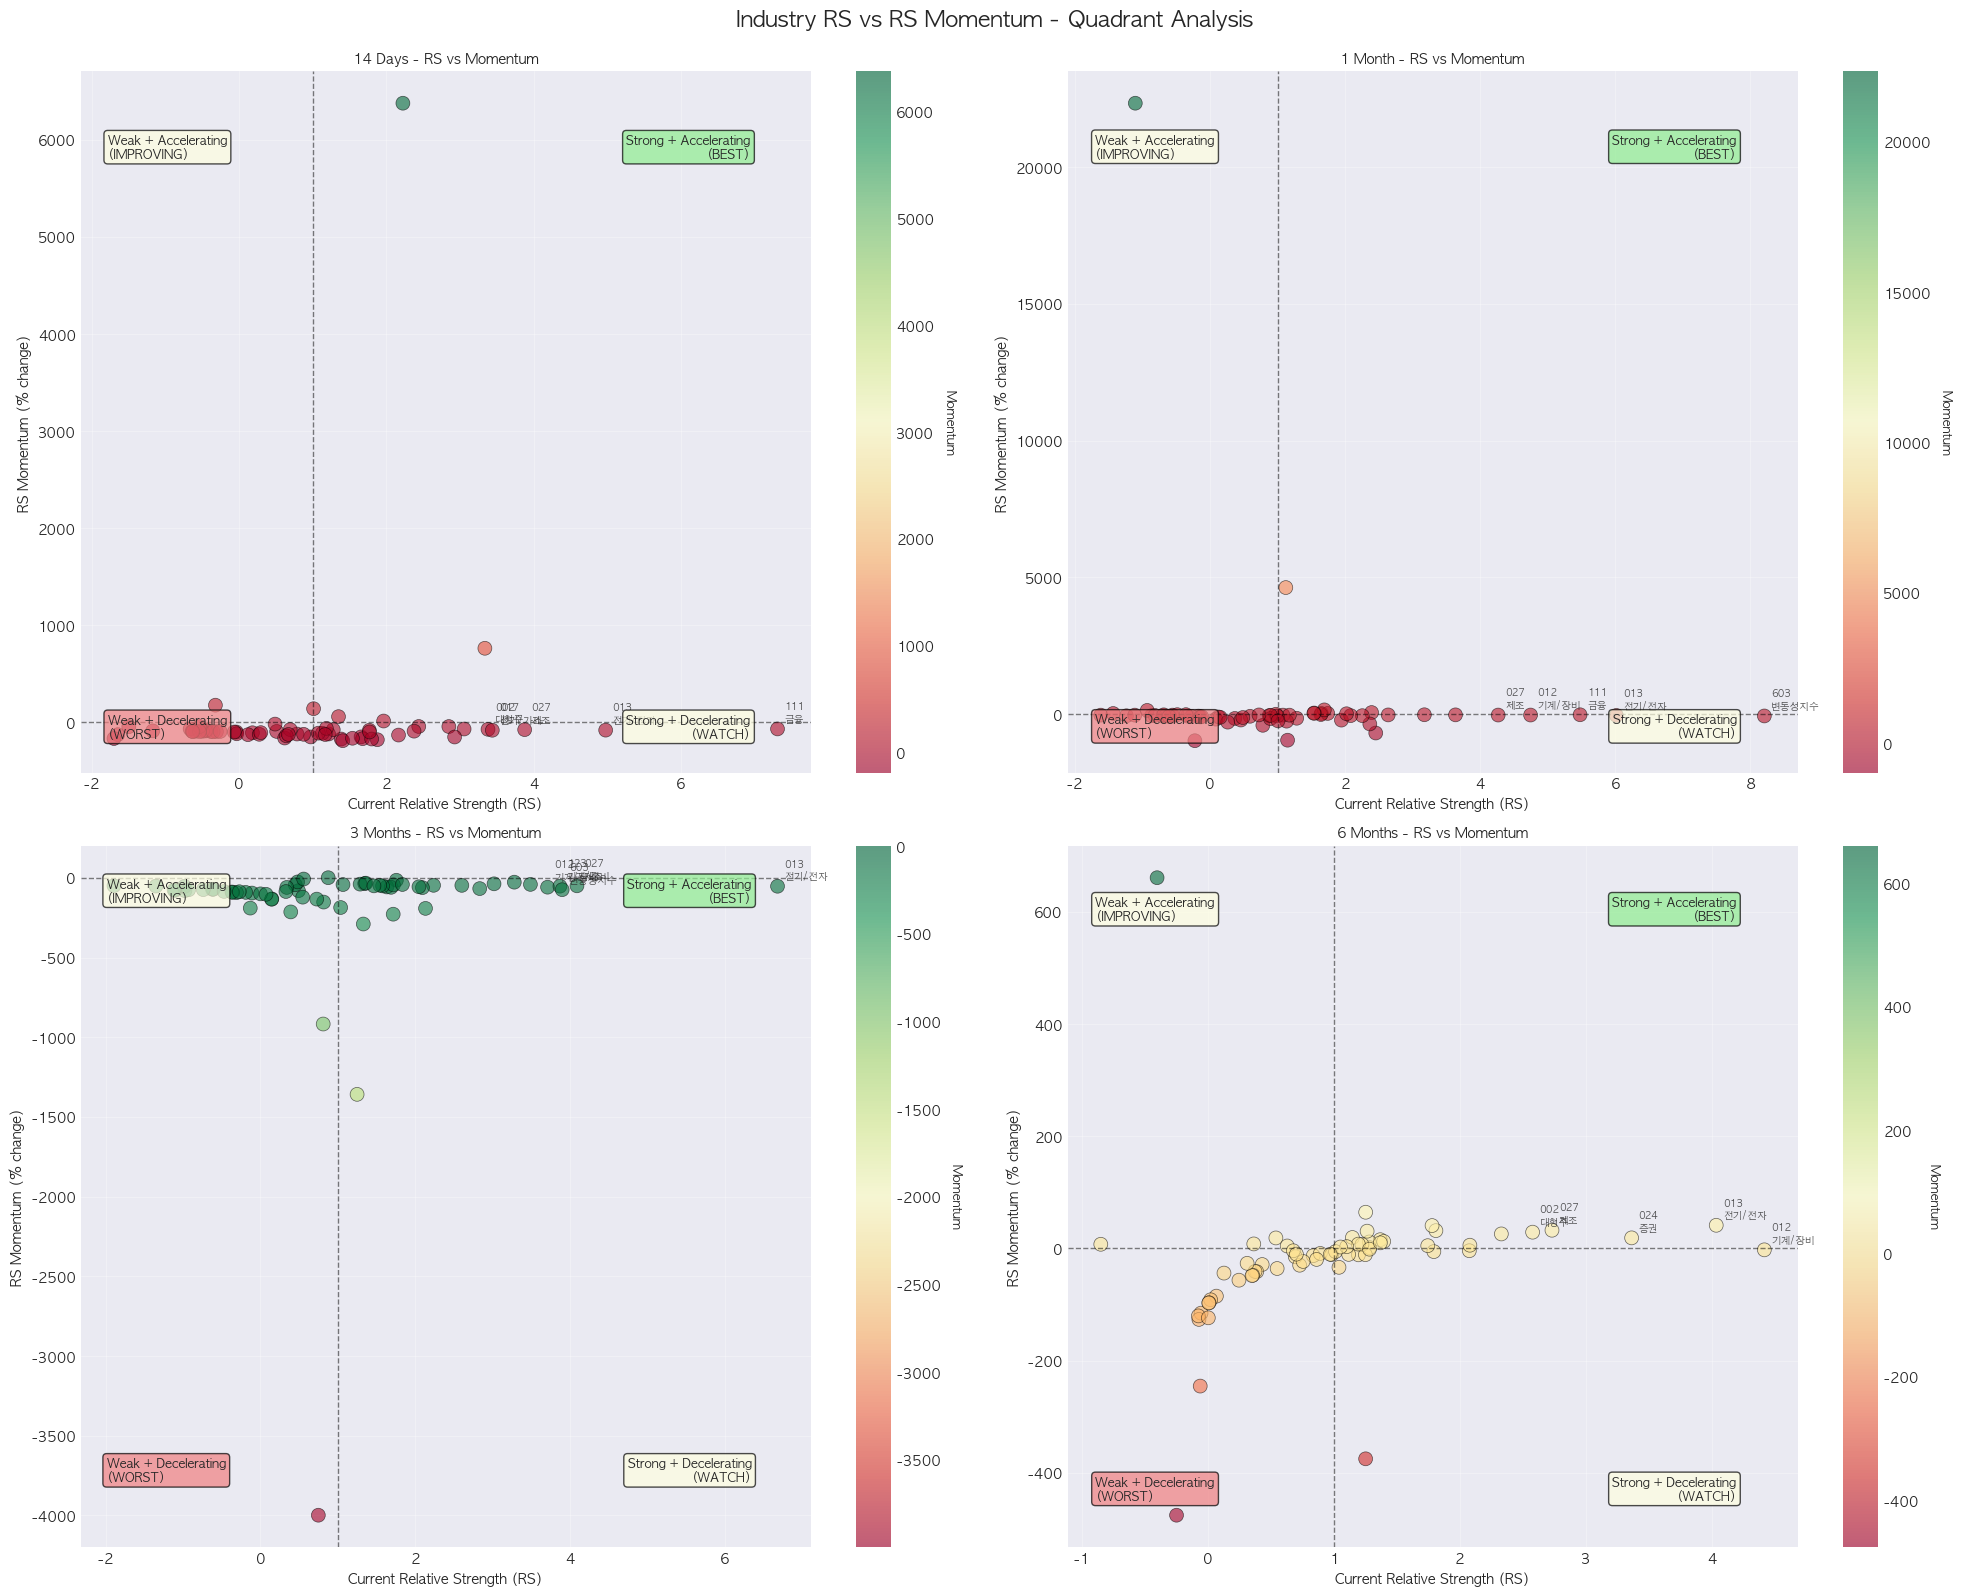

In [11]:
# RS Momentum Visualization
def plot_rs_momentum(current_rs, current_momentum, industry_codes_df):
    """
    Create scatter plot of Current RS vs RS Momentum
    Quadrants:
    - Top Right: Strong RS + Positive Momentum (Best)
    - Top Left: Weak RS + Positive Momentum (Improving)
    - Bottom Right: Strong RS + Negative Momentum (Deteriorating)
    - Bottom Left: Weak RS + Negative Momentum (Worst)
    """
    
    # Get Korean font for text rendering
    korean_font = get_korean_font()
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Industry RS vs RS Momentum - Quadrant Analysis', 
                 fontsize=16, fontweight='bold', y=0.995, fontproperties=korean_font)
    
    axes = axes.flatten()
    periods = ['14d', '1m', '3m', '6m']
    period_labels = {'14d': '14 Days', '1m': '1 Month', '3m': '3 Months', '6m': '6 Months'}
    
    for idx, period in enumerate(periods):
        ax = axes[idx]
        
        # Get RS and momentum values
        rs_vals = current_rs[period]
        mom_vals = current_momentum[period]
        
        # Merge data
        plot_data = pd.DataFrame({
            'rs': rs_vals,
            'momentum': mom_vals
        }).dropna()
        
        # Create scatter plot
        scatter = ax.scatter(plot_data['rs'], plot_data['momentum'], 
                           c=plot_data['momentum'], cmap='RdYlGn', 
                           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(x=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Label top performers and worst performers
        top_5_rs = plot_data.nlargest(5, 'rs')
        bottom_5_rs = plot_data.nsmallest(5, 'rs')
        
        for code in top_5_rs.index:
            name = industry_codes_df[industry_codes_df['code'] == code]['name'].values[0] if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
            # Don't truncate Korean text
            ax.annotate(f"{code}\n{name}", 
                       xy=(plot_data.loc[code, 'rs'], plot_data.loc[code, 'momentum']),
                       xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8,
                       fontproperties=korean_font)
        
        # Add quadrant labels with proper newlines
        y_max = plot_data['momentum'].max()
        y_min = plot_data['momentum'].min()
        x_max = plot_data['rs'].max()
        x_min = plot_data['rs'].min()
        
        ax.text(x_max*0.95, y_max*0.95, 'Strong + Accelerating\n(BEST)', 
               ha='right', va='top', fontsize=9, fontweight='bold', 
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
               fontproperties=korean_font)
        
        ax.text(x_min*1.05, y_max*0.95, 'Weak + Accelerating\n(IMPROVING)', 
               ha='left', va='top', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
               fontproperties=korean_font)
        
        ax.text(x_max*0.95, y_min*0.95, 'Strong + Decelerating\n(WATCH)', 
               ha='right', va='bottom', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
               fontproperties=korean_font)
        
        ax.text(x_min*1.05, y_min*0.95, 'Weak + Decelerating\n(WORST)', 
               ha='left', va='bottom', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
               fontproperties=korean_font)
        
        ax.set_title(f'{period_labels[period]} - RS vs Momentum', fontsize=12, fontweight='bold',
                    fontproperties=korean_font)
        ax.set_xlabel('Current Relative Strength (RS)', fontsize=10, fontproperties=korean_font)
        ax.set_ylabel('RS Momentum (% change)', fontsize=10, fontproperties=korean_font)
        ax.grid(True, alpha=0.3)
        
        # Apply Korean font to tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(korean_font)
        
        # Add colorbar with Korean font
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Momentum', rotation=270, labelpad=15, fontsize=9, fontproperties=korean_font)
        for label in cbar.ax.get_yticklabels():
            label.set_fontproperties(korean_font)
    
    plt.tight_layout()
    plt.show()

# Plot RS momentum
plot_rs_momentum(current_rs, current_momentum, industry_codes_df)

In [12]:
# Top and Bottom Performers Summary Tables
def create_performers_summary(current_rs, current_momentum, industry_codes_df, n=10):
    """Create detailed summary tables of top and bottom performers"""
    
    summaries = {}
    
    for period in ['14d', '1m', '3m', '6m']:
        # Get RS and momentum
        rs_series = current_rs[period]
        mom_series = current_momentum[period]
        
        # Combine into DataFrame
        combined = pd.DataFrame({
            'rs': rs_series,
            'momentum': mom_series
        }).dropna()
        
        # Add industry info
        combined['name'] = combined.index.map(
            lambda code: industry_codes_df[industry_codes_df['code'] == code]['name'].values[0]
            if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 else code
        )
        combined['market'] = combined.index.map(
            lambda code: industry_codes_df[industry_codes_df['code'] == code]['market'].values[0]
            if len(industry_codes_df[industry_codes_df['code'] == code]) > 0 and 
               'market' in industry_codes_df.columns else ''
        )
        
        # Sort by RS
        combined = combined.sort_values('rs', ascending=False)
        
        # Get top and bottom
        top_n = combined.head(n).copy()
        bottom_n = combined.tail(n).copy()
        
        top_n['rank'] = range(1, len(top_n) + 1)
        bottom_n['rank'] = range(len(combined) - len(bottom_n) + 1, len(combined) + 1)
        
        summaries[period] = {
            'top': top_n[['rank', 'name', 'market', 'rs', 'momentum']],
            'bottom': bottom_n[['rank', 'name', 'market', 'rs', 'momentum']]
        }
    
    return summaries

# Create performers summaries
performers = create_performers_summary(current_rs, current_momentum, industry_codes_df, n=10)

# Display results
period_labels = {'14d': '14 Days', '1m': '1 Month', '3m': '3 Months', '6m': '6 Months'}

for period in ['14d', '1m', '3m', '6m']:
    print(f"\n{'='*100}")
    print(f"  {period_labels[period].upper()} PERIOD - TOP & BOTTOM PERFORMERS")
    print(f"{'='*100}\n")
    
    print(f"🏆 TOP 10 STRONGEST INDUSTRIES (by RS):")
    print("-" * 100)
    display(performers[period]['top'].style.format({
        'rs': '{:.3f}',
        'momentum': '{:.2f}%'
    }).background_gradient(subset=['rs'], cmap='Greens'))
    
    print(f"\n⚠️  BOTTOM 10 WEAKEST INDUSTRIES (by RS):")
    print("-" * 100)
    display(performers[period]['bottom'].style.format({
        'rs': '{:.3f}',
        'momentum': '{:.2f}%'
    }).background_gradient(subset=['rs'], cmap='Reds'))


  14 DAYS PERIOD - TOP & BOTTOM PERFORMERS

🏆 TOP 10 STRONGEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
111,1,금융,KOSDAQ,7.315,-66.73%
013,2,전기/전자,KOSPI,4.980,-79.32%
027,3,제조,KOSPI,3.880,-74.03%
017,4,전기/가스,KOSPI,3.440,-80.33%
002,5,대형주,KOSPI,3.382,-70.65%
015,6,운송장비/부품,KOSPI,3.339,763.84%
001,7,종합(KOSPI),KOSPI,3.057,-67.60%
024,8,증권,KOSPI,2.928,-149.90%
008,9,화학,KOSPI,2.849,-42.20%



⚠️  BOTTOM 10 WEAKEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
122,56,금속,KOSDAQ,-0.538,-42.87%
128,57,통신,KOSDAQ,-0.539,-94.37%
108,58,유통,KOSDAQ,-0.595,-90.17%
141,59,오락/문화,KOSDAQ,-0.628,-95.25%
129,60,IT 서비스,KOSDAQ,-0.638,-91.63%
116,61,섬유/의류,KOSDAQ,-0.666,-66.13%
115,62,음식료/담배,KOSDAQ,-1.173,-86.84%
127,63,기타제조,KOSDAQ,-1.499,-43.70%
121,64,비금속,KOSDAQ,-1.649,-125.55%



  1 MONTH PERIOD - TOP & BOTTOM PERFORMERS

🏆 TOP 10 STRONGEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
603,1,변동성지수,KOSPI,8.210,-66.64%
013,2,전기/전자,KOSPI,6.018,-47.53%
111,3,금융,KOSDAQ,5.480,-23.14%
012,4,기계/장비,KOSPI,4.747,-33.46%
027,5,제조,KOSPI,4.267,-33.58%
002,6,대형주,KOSPI,3.635,-26.47%
001,7,종합(KOSPI),KOSPI,3.174,-22.86%
017,8,전기/가스,KOSPI,2.637,-28.53%
015,9,운송장비/부품,KOSPI,2.453,-690.60%



⚠️  BOTTOM 10 WEAKEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
125,56,의료/정밀기기,KOSDAQ,-0.688,-25.92%
006,57,섬유/의류,KOSPI,-0.706,-66.28%
117,58,종이/목재,KOSDAQ,-0.817,-49.59%
110,59,운송/창고,KOSDAQ,-0.869,-59.49%
116,60,섬유/의류,KOSDAQ,-0.933,136.58%
127,61,기타제조,KOSDAQ,-1.109,22335.47%
129,62,IT 서비스,KOSDAQ,-1.117,-36.49%
128,63,통신,KOSDAQ,-1.240,-61.16%
165,64,F-KOSDAQ150인버스,KOSDAQ,-1.437,23.45%



  3 MONTHS PERIOD - TOP & BOTTOM PERFORMERS

🏆 TOP 10 STRONGEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
013,1,전기/전자,KOSPI,6.681,-52.30%
027,2,제조,KOSPI,4.090,-49.61%
603,3,변동성지수,KOSPI,3.899,-73.95%
123,4,기계/장비,KOSDAQ,3.870,-51.80%
012,5,기계/장비,KOSPI,3.710,-58.19%
002,6,대형주,KOSPI,3.489,-40.73%
111,7,금융,KOSDAQ,3.280,-26.75%
001,8,종합(KOSPI),KOSPI,3.018,-37.08%
121,9,비금속,KOSDAQ,2.833,-67.07%



⚠️  BOTTOM 10 WEAKEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
020,56,통신,KOSPI,-0.609,-71.59%
010,57,비금속,KOSPI,-0.620,-71.44%
115,58,음식료/담배,KOSDAQ,-0.739,-73.78%
129,59,IT 서비스,KOSDAQ,-0.927,-74.39%
006,60,섬유/의류,KOSPI,-0.976,-80.11%
127,61,기타제조,KOSDAQ,-0.981,-52.89%
110,62,운송/창고,KOSDAQ,-1.103,-78.49%
128,63,통신,KOSDAQ,-1.116,-75.47%
165,64,F-KOSDAQ150인버스,KOSDAQ,-1.350,-51.41%



  6 MONTHS PERIOD - TOP & BOTTOM PERFORMERS

🏆 TOP 10 STRONGEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
012,1,기계/장비,KOSPI,4.417,-2.54%
013,2,전기/전자,KOSPI,4.035,41.26%
024,3,증권,KOSPI,3.364,18.79%
027,4,제조,KOSPI,2.732,32.44%
002,5,대형주,KOSPI,2.578,28.95%
001,6,종합(KOSPI),KOSPI,2.330,25.82%
021,7,금융,KOSPI,2.080,5.70%
017,8,전기/가스,KOSPI,2.076,-4.13%
015,9,운송장비/부품,KOSPI,1.811,31.71%



⚠️  BOTTOM 10 WEAKEST INDUSTRIES (by RS):
----------------------------------------------------------------------------------------------------


,rank,name,market,rs,momentum
industry_code,,,,,
110,56,운송/창고,KOSDAQ,0.010,-96.89%
129,57,IT 서비스,KOSDAQ,0.008,-97.29%
118,58,출판/매체복제,KOSDAQ,0.005,-123.79%
006,59,섬유/의류,KOSPI,-0.053,-115.47%
007,60,종이/목재,KOSPI,-0.060,-245.54%
115,61,음식료/담배,KOSDAQ,-0.070,-126.63%
116,62,섬유/의류,KOSDAQ,-0.074,-120.35%
117,63,종이/목재,KOSDAQ,-0.248,-475.81%
127,64,기타제조,KOSDAQ,-0.402,661.09%


In [13]:
# Summary Statistics
print("\\n" + "="*100)
print("  INDUSTRY RELATIVE STRENGTH (RS) ANALYSIS SUMMARY")
print("="*100 + "\\n")

print("📊 Dataset Overview:")
print(f"  • Total Industries: {len(industry_codes_df)}")
print(f"  • Date Range: {price_pivot.index.min().strftime('%Y-%m-%d')} to {price_pivot.index.max().strftime('%Y-%m-%d')}")
print(f"  • Total Trading Days: {len(price_pivot)}")

print("\\n📈 RS Calculation Method:")
print("  • Benchmark: Equal-weighted market average")
print("  • Formula: RS = (Industry % change) / (Market average % change)")
print("  • Interpretation:")
print("    - RS > 1.0 = Outperforming market")
print("    - RS = 1.0 = Matching market performance")
print("    - RS < 1.0 = Underperforming market")

print("\\n⏱️  Analysis Periods:")
for period, days in [('14d', 14), ('1m', 21), ('3m', 63), ('6m', 126)]:
    print(f"  • {period}: {days} trading days lookback")

print("\\n📉 RS Momentum:")
print("  • Lookback: 10 days")
print("  • Positive momentum = RS improving")
print("  • Negative momentum = RS deteriorating")

print("\\n🎯 Key Insights:")
for period in ['14d', '1m', '3m', '6m']:
    top_industry = current_rs[period].idxmax()
    top_rs = current_rs[period].max()
    top_name = industry_codes_df[industry_codes_df['code'] == top_industry]['name'].values[0]
    
    bottom_industry = current_rs[period].idxmin()
    bottom_rs = current_rs[period].min()
    bottom_name = industry_codes_df[industry_codes_df['code'] == bottom_industry]['name'].values[0]
    
    print(f"\\n  {period.upper()}:")
    print(f"    • Strongest: {top_industry} ({top_name[:30]}) - RS = {top_rs:.3f}")
    print(f"    • Weakest: {bottom_industry} ({bottom_name[:30]}) - RS = {bottom_rs:.3f}")

print("\\n" + "="*100)
print("Analysis complete! Use the visualizations above to identify investment opportunities.")
print("="*100)

\n====================================================================================================
  INDUSTRY RELATIVE STRENGTH (RS) ANALYSIS SUMMARY
====================================================================================================\n
📊 Dataset Overview:
  • Total Industries: 65
  • Date Range: 2022-11-02 to 2025-10-31
  • Total Trading Days: 732
\n📈 RS Calculation Method:
  • Benchmark: Equal-weighted market average
  • Formula: RS = (Industry % change) / (Market average % change)
  • Interpretation:
    - RS > 1.0 = Outperforming market
    - RS = 1.0 = Matching market performance
    - RS < 1.0 = Underperforming market
\n⏱️  Analysis Periods:
  • 14d: 14 trading days lookback
  • 1m: 21 trading days lookback
  • 3m: 63 trading days lookback
  • 6m: 126 trading days lookback
\n📉 RS Momentum:
  • Lookback: 10 days
  • Positive momentum = RS improving
  • Negative momentum = RS deteriorating
\n🎯 Key Insights:
\n  14D:
    • Strongest: 111 (금융) - RS = 7.315
    • W